# Análisis de sentimientos
La **clasificación de texto** es un proceso involucrado en el análisis de sentimientos. Es la clasificación de las opiniones o expresiones de las personas como, por ejemplo, en positivas, neutrales o negativas. Este análisis de sentimientos puede ser realizado en diferentes industrias centradas en el cliente para analizar la opinión de las personas sobre un producto o tema en concreto.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importe de librerías
Se importan todas las librerías necesarias para el proyecto.

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import mlflow
import re
import csv
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from keras.layers import TextVectorization
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###  Preprocesamiento de datos
El `dataset` elegido contiene datos etiquetados de 1.6M de tweets.

In [5]:
# Se pasa el parámetro 'names' para establecer la lista de columnas que tendrá el 'dataframe',
# ya que sin ellos hay errores porque el delimitador (,) aparece en las citas de los tweets y
# crea más columnas de las necesarias
df = pd.read_csv('/content/drive/MyDrive/twitter_dataset.csv', encoding='latin', header=None,
                 names=['sentiment', 'id', 'date', 'query', 'user_id', 'text'])
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Como se ha dicho, el entrenamiento solo va a ser para clasificar los sentimientos según los tweets, por lo que se eliminan las columnas que no sirven, quedando solo las columnas `sentiment` y `text`.

In [6]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Se comprueba cuales son los valores de las etiquetas de salida.

In [7]:
df['sentiment'].value_counts()

sentiment
0    800000
4    800000
Name: count, dtype: int64

La columna `sentiment` tiene dos valores enteros: cero para las opiniones o `tweets` negativos, y cuatro para las opiniones positivas. Por tanto, se va a cambiar el valor de los enteros por estos `strings` (`negativo` si es cero, y `positivo` si es uno).

In [8]:
# Con 'apply' se aplica la función lambda sobre la columna 'sentiment'
df['sentiment'] = df['sentiment'].apply(lambda x: 'Negativo' if x == 0 else 'Positivo')
df.head()

,sentiment,text
0,Negativo,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negativo,is upset that he can't update his Facebook by ...
2,Negativo,@Kenichan I dived many times for the ball. Man...
3,Negativo,my whole body feels itchy and like its on fire
4,Negativo,"@nationwideclass no, it's not behaving at all...."


Al usar `tweets`, estos normalmente tienen palabras mal escritas o muchos signos de puntuación emojis y demás elementos que no aportan ningún significado contextual de valor, por lo que hay que deshacerse de ellos.

### Preprocesamiento de texto (columna `text`)
Es hora de limpiar los `tweets` con distintos métodos y técnicas.


#### Stemming/Lemmatization
Los documentos utilizan diferentes formas de una palabra, como *escribir, escribir o escribe.* Además, existen familias de palabras relacionadas con significados similares. El objetivo tanto del *stemming* como de la *lemmatization* es reducir las formas flexivas y derivadas de las palabras para tener solamente una base común para una palabra.

- El *stemming* es un método para reducir una palabra a su raíz.

- La *lemmatization* es el proceso de agrupar conjuntamente las formas flexivas de una palabra de forma que puedan ser analizadas como un solo item, identificados por el lema de la palabra.

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/0*a8k0O3iAvWUxCPlX" alt="Stemming y lemmatization"/>
</p>

#### Hipervínculos y menciones
`Twitter` es una red social donde la gente puede etiquetar y mencionar, además de compartir vídeos de internet, por lo que a veces contienen hipervínculos y menciones.

#### Stopwords
Las *Stopwords* o palabras vacías son palabras usadas normalmente que no tienen ningún significado contextual en una frase, por lo que también se deben eliminar. En esta imagen se muestran algunas de ellas:

<p align="center">
  <img src="https://www.researchgate.net/profile/Jennifer-Priestley/publication/318138987/figure/fig8/AS:668237603803162@1536331668931/List-of-Stopwords-in-Text-Mining-Library-of-R.png" alt="stopwords"/>
</p>

Todo este preprocesamiento del texto se va a realizar con la librería `NLTK` de `Python` que tiene funciones para realizar tareas de este tipo para procesamiento del lenguaje natural (`NLP`).

In [9]:
# Lista de 'stopwords' del idioma inglés
stop_words = stopwords.words('english')

# Se inicia un objeto de 'stemming' (elimina sufijos) para el idioma inglés
stemmer = SnowballStemmer('english')

# Expresion regular para filtrar:
# - Las menciones el mayor número de veces posible
# - Los hipervínculos con http
# - Los hipervínculos con https
# - Cualquier caract[^A-Za-z0-9]
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

Se realiza el procesamiento de la columna `text` del `dataframe`.

In [10]:
# Función para preprocesar cada observación o línea de la columna 'text' con
# la función de 'stemming' (eliminado de sufijos) desactivada por defecto
def preprocess(text, stem=False):

  # Se sustituye cualquiera de las 'regular expression' definida arriba por
  # un espacio en la frase del parámetro 'string' (que será la frase de cada observación
  # de la columna 'text' del 'dataframe')
  text = re.sub(pattern=text_cleaning_re, repl=' ', string=str(text).lower()).strip()

  # Se crea una lista vacía
  tokens = []

  # Para cada 'token' (palabra) de la línea...
  for token in text.split():

    # Si el 'token' no está dentro de la lista de 'stopwords', se añade a la
    # lista creada arriba
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)

  # Una vez se tiene toda la lista de palabras sin las 'stopwords', ésta se une
  # mediante un espacio entre cada uno de sus elementos, por lo que al final se
  # retorna una frase
  return " ".join(tokens)

# Se aplica la función definida arriba a la columna 'text'
df['text'] = df['text'].apply(lambda x: preprocess(x))

Ahora la columna `text` esta preprocesada y limpia de hipervínculos, menciones y `stopwords`.

In [11]:
df['text'].head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save 50 rest go ...
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

### Nube de palabras

Una nube de palabras o nube de etiquetas es una representación visual de las palabras que conforman un texto, en donde el tamaño es mayor para las palabras que aparecen con más frecuencia.

#### Nube de palabras positivas

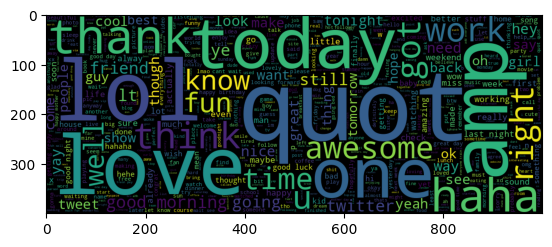

In [12]:
plt.figure()

# Se calcula la nube de palabras positiva con 1000 palabras como máximo a partir
# de la columna 'text' en los que el sentimiento es positivo
wc = WordCloud(max_words=1000, width=1000, height=400).generate(" ".join(df.loc[df['sentiment'] == 'Positivo'].text))

# Se muestra la nube de palabras
plt.imshow(wc)

#### Nube de palabras negativas

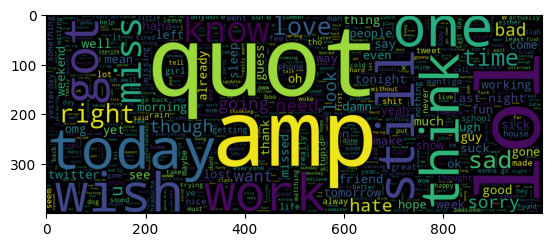

In [13]:
plt.figure()

# Se calcula la nube de palabras positiva con 1000 palabras como máximo a partir
# de la columna 'text' en los que el sentimiento es negativo
wc = WordCloud(max_words=1000, width=1000, height=400).generate(" ".join(df.loc[df['sentiment'] == 'Negativo'].text))

# Se muestra la nube de palabras
plt.imshow(wc)

Aunque hay palabras que se repiten en ambas nubes, hay algunas que solo aparecen en la nube de palabras positivas como por ejemplo `love` o `haha`; y otras que solo aparecen en la nube de palabrass negativas, como `miss` o `work`.

### Repartición entrenamiento-test

Una vez procesado el `dataset` y el texto de la columna `text` se realiza la repartición de datos en subconjuntos de entrenamiento, validación y test.

In [14]:
# Repartición entrenamiento/val - test (80% - 20%)
train_val_data, test_data = train_test_split(df, test_size=0.2, random_state=42,
                                             stratify=df['sentiment'])

# Repartición entrenamiento - val (80% - 20%)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42,
                                        stratify=train_val_data['sentiment'])

print("Tamaño subconjunto de entrenamiento:", len(train_data))
print("Tamaño subconjunto de validación:", len(val_data))
print("Tamaño subconjunto de test:", len(test_data))

Tamaño subconjunto de entrenamiento: 1024000
Tamaño subconjunto de validación: 256000
Tamaño subconjunto de test: 320000


Se imprimen las primeras filas del `dataset` de entrenamiento para comprobar que todo se muestra tal y como debería.

In [15]:
train_data.head()

,sentiment,text
134801,Negativo,sianysianysiany must twiglets must roast pork ...
1488880,Positivo,take time usual job run polling station amp co...
154059,Negativo,cannot get creepy sister shit
1309597,Positivo,come stay one night hit town
967862,Positivo,audio laurenmalone made laugh


### Tokenización

Dada una secuencia de caracteres y una unidad de documento definida, la `tokenización` es la tarea de separarla en trozos llamados `tokens`, desechando quizás, al mismo tiempo, ciertos caracteres sin significado como los signos de puntuación.

Una vez se tienen los distintos `tokens`, estos se mapean a números enteros, de forma que cada uno de ellos se corresponde con un número entero único.

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1378/1*3CNBx4iZ1vmJCZgGUIC83A.png" alt="Tokenización"/>
</p>

### Padding

Dado que se va a construir un modelo secuencial, se debe introducir una secuencia de números a dicho modelo. Además, hay que asegurarse que hay homogeneidad en los `shapes` de entrada de las secuencias, es decir, todas ellas deben tener la misma longitud. Como los `tweets` tienen una cantidad variables de caracteres esto también se debe solucionar con alguna técnica, de forma que se rellene o trunque cada `token` a una longitud determinada.

Es decir, siguiendo el ejemplo anterior, cada frase (`tweet`) debe tener el mismo número de `tokens` tras aplicar el `padding`.

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/1*I0JbAgArgFzMCWiOB1o9CQ.png" alt="Padding NLP"/>
</p>

El `tokenizer` y el `padding` se realizaba anteriormente en `Keras` de forma separada con dos funciones: con `Tokenizer` (deprecado) y con `pad_sequences`. Sin embargo, ahora hay una función que realiza ambas cosas conjuntamente, y es `TextVectorization`.

In [16]:
# Se crea una capa de vectorización de texto que mapea el texto a secuencias de
# números enteros (parámetro 'output_mode' como 'int') estableciendo un número
# máximo de 'tokens' a usar (100000) y un máximo de longitud de secuencia (30),
# por lo que se rellena o trunca cada 'token' a esta longitud para que las
# secuencias de todos ellos sean iguales
vectorize_layer = TextVectorization(standardize="lower_and_strip_punctuation",
                                    max_tokens=100000, output_mode="int",
                                    output_sequence_length=30)

# La capa de vectorización construye el vocabulario de números enteros a partir
# de la columna 'text' (una serie de 'pandas') del subconjunto de entrenamiento
vectorize_layer.adapt(train_data['text'])

# Se imprime la longitud del vocabulario de 'tokens' (debe ser 100000)
print(len(vectorize_layer.get_vocabulary()))

100000


Una vez se construye el vocabulario, se muestra como se aplica la capa de vectorización a una frase del subconjunto de entrenamiento:

In [17]:
vectorize_layer(train_data['text'][:1])

<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[    1,   220, 42708,   220,  3245,  4162,   240,   444,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]])>

Como se puede apreciar, tras aplicar la capa de vectorización la frase se convierte a un `array` de longitud treinta (establecido en el parámetro `output_sequence_length`) en el que nueve valores son números enteros distintos de cero (porque la frase tiene nueve palabras o `tokens`) y los valores restantes son cero (de relleno hasta llegar a la longitud de treinta, puesto que la frase en este caso solo tenía nueve palabras o `tokens`).

### Codificación de las clases de salida

Se construye el modelo para predecir las clases de salida en formato codificado como en los problemas de visión artificial. Así, se tiene `0` o `1` dependiendo de los sentimientos de los `tweets`, por lo que este problema es de clasificación binaria.

In [18]:
# Objeto 'LabelEncoder'
encoder = LabelEncoder()

# Se entrena el objeto 'LabelEncoder' con las etiquetas de entrenamiento
encoder.fit(train_data['sentiment'].to_list())

# Una vez entrenado el objeto, se transforma en los tres subconjuntos para obtener
# números enteros como salida
y_train = encoder.transform(train_data['sentiment'].to_list())  # (1024000,)
y_val = encoder.transform(val_data['sentiment'].to_list())
y_test = encoder.transform(test_data['sentiment'].to_list())

# Se hace 'reshape' de las etiquetas para añadir una nueva dimensión
y_train = y_train.reshape(-1,1)                                 # (1024000, 1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

### Word Embedding

En los modelos de lenguaje, las palabras se representan para buscar más significado y para aprender los patrones y el significado contextual detrás de ellas.

El encaje léxico o `word embedding` es una de las representaciones más populares del vocabulario de documentos. Es capaz de capturar el contexto de una palabra en un documento, la similaridad semántica y sintática, las relaciones con otras palabras, etc.

Básicamente, es una representación vectorial de palabras que se utilizan para otras aplicaciones del procesamiento del lenguaje natural.

Se puede entrenar el `embedding`, aunque eso también conlleva que el tiempo de entrenamiento aumente; o se puede hacer `transfer learning` y descargar un `embedding` pre-entrenado y usarlo en el modelo como [GloVe & Word2Vec](https://nlp.stanford.edu/projects/glove/)

### Experimento MLflow

Se crea un experimento de `MLflow` para registrar las métricas, parámetros y modelos del problema actual.

In [19]:
%cd /content/drive/MyDrive
if os.path.exists('/content/drive/MyDrive/mlflow'):
  %cd mlflow
else:
  !mkdir mlflow
  %cd mlflow

/content/drive/MyDrive
/content/drive/MyDrive/mlflow


In [20]:
# Se establece el URI de seguimiento. En 'Colab' no se elige nada, por lo que
# los datos se almacenan localmente en la carpeta '/mlruns'
mlflow.set_tracking_uri('./mlruns')

# Si el experimento con nombre 'Sentiment_Analysis' existe se usa, ya que ya ha
# sido creado; y si no existe, pues se crea
if len(mlflow.search_experiments(filter_string="name ='Sentiment_Analysis'")) > 0:
    experiment = mlflow.get_experiment_by_name('Sentiment_Analysis')  # Devuelve la instancia del experimento
else:
    experiment_id = mlflow.create_experiment("Sentiment_Analysis")    # Devuelve el ID del experimento creado

### Entrenamiento del modelo
Ya es hora de entrenar el modelo.

Como se pudo comprobar anteriormente en la nube de palabras de ambas clases, hay algunas palabras que se repiten tanto en los `tweets` positivos como negativos. Esto podría ser un problema si utilizamos un modelo de aprendizaje automático como por ejemplo, un clasificador bayesiano. Por este motivo, se usa un modelo secuencial:

<p align="center">
  <img src="https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png" alt="Modelo secuencial"/>
</p>

Las redes neuronales recurrentes pueden manejar una secuencia de datos y aprender un patrón de secuencia de entrada para dar una secuencia o un valor escalar como salida. En estes caso, la red neuronal genera una predicción de un valor escalar.

Para la arquitectura del modelo se usa:

1) **Capa Embedding**: Genera un vector `embedding` para cada `token`, es decir, realiza una representación vectorial de tamaño fijo de cada una de ellos, por lo que cada frase sera una lista de una representación vectorial de todos sus `tokens`.

2) **Capa Conv1D**: Usada para convolucionar los datos en vectores de características más pequeños.

3) **Capa LSTM (Long Short Term Memory)**: Es una variante de una red neuronal recurrente que tiene una celda de estado de memoria para aprender el contexto de las palabras que se encuentran más adelante en el texto para transmitir un significado contextual.

4) **Capa Densa**: Capa completamente conectada para realizar la parte de clasificación.


In [21]:
# Capa de entrada
sequence_input = layers.Input(shape=(1,), dtype=tf.string, name='text')

# Se aplica la capa de vectorización a la capa de entrada
x = vectorize_layer(sequence_input)

# La entrada de la capa 'Embedding' es del tamaño del vocabulario + 1; y la salida
# es de el tamaño del vocabulario elevado a 0.25
x = layers.Embedding(input_dim=100000 + 1, output_dim=18)(x) # 128
x = layers.SpatialDropout1D(0.2)(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)

# Activación sigmoide para problemas binarios como éste
prediction = layers.Dense(1, activation='sigmoid', name='predictions')(x)

# Se construye el modelo especificando la capa de entrada y la de salida
model = tf.keras.Model(inputs=sequence_input, outputs=prediction)

# Resumen del modelo
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 30)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 30, 18)            1800018   
                                                                 
 spatial_dropout1d (Spatial  (None, 30, 18)            0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            5824      
                                                                 
 bidirectional (Bidirection  (None, 128)               66048 

Una vez definida la estructura de la red, se compila el modelo con una función de pérdida óptima para problemas de clasificación binaria y con el optimizador `Adam`, que suele ser el que más rendimiento tiene. Además, se define la métrica que se va a ir examinando, que es la `accuracy`.

In [22]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',
              metrics=['accuracy'])

Ahora se definen dos `callbacks`, las funciones que se llaman al final de cada `epoch`. Se va a optar por uno para reducir el `learning rate` si las métricas de validación no mejoran al cabo de 3 `epochs`; otro para ir guardando el mejor modelo según la `loss` de validación; y un último para parar el entrenamiento si la `loss`de validación no mejora después de dos `epochs`.<br>
Nota: `checkpoint` no se usa, ya que el modelo se va a guardar con `MLflow`.

In [23]:
reduce_lr = ReduceLROnPlateau(factor=0.1, min_lr = 0.0001, monitor = 'val_loss',
                              patience = 2)
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/nlp_model',
                             monitor = 'val_loss', mode = 'min',
                             save_best_only = True)
stop_train = EarlyStopping(patience=3)

Una vez compilado y configurado los `callbacks`, se entrena el modelo:

In [24]:
# Inicia ejecución 'tensorflow' dentro del experimento 'sentiment_analysis'
with mlflow.start_run(experiment_id=experiment_id, run_name="tensorflow") as run:

  # Autologging en TensorFlow
  mlflow.tensorflow.autolog(registered_model_name='tf_model')

  # Entrenamiento del modelo
  history = model.fit(x=train_data['text'], y=y_train, batch_size=1024,
                      callbacks=[reduce_lr, stop_train],
                      epochs=7, validation_data=(val_data['text'], y_val))

2024/05/03 18:54:26 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2024/05/03 18:54:26 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/7
1000/1000 [==============================] - ETA: 0s - loss: 0.4878 - accuracy: 0.7615

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024/05/03 18:58:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.src.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7f3a24d8dae0>]


1000/1000 [==============================] - 262s 249ms/step - loss: 0.4878 - accuracy: 0.7615 - val_loss: 0.4558 - val_accuracy: 0.7842 - lr: 0.0010
Epoch 2/7
1000/1000 [==============================] - ETA: 0s - loss: 0.4385 - accuracy: 0.7955

2024/05/03 19:02:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.src.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7f3a24d8dae0>]


1000/1000 [==============================] - 213s 213ms/step - loss: 0.4385 - accuracy: 0.7955 - val_loss: 0.4517 - val_accuracy: 0.7852 - lr: 0.0010
Epoch 3/7
1000/1000 [==============================] - 216s 216ms/step - loss: 0.4162 - accuracy: 0.8073 - val_loss: 0.4563 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 4/7
1000/1000 [==============================] - 209s 209ms/step - loss: 0.3963 - accuracy: 0.8178 - val_loss: 0.4681 - val_accuracy: 0.7825 - lr: 0.0010
Epoch 5/7
1000/1000 [==============================] - 213s 213ms/step - loss: 0.3616 - accuracy: 0.8361 - val_loss: 0.4861 - val_accuracy: 0.7808 - lr: 1.0000e-04


2024/05/03 19:13:01 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2024/05/03 19:13:56 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/05/03 19:14:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
Successfully registered model 'tf_model'.
Created version '1' of model 'tf_model'.


### Evaluación del modelo

Una vez el modelo ha sido entrenado se puede evaluar su rendimiento mediante métricas y predicciones sobre el subconjunto de `test`. Primero se analiza la evolución de la `loss` y la `accuracy` del modelo en cada `epoch`.

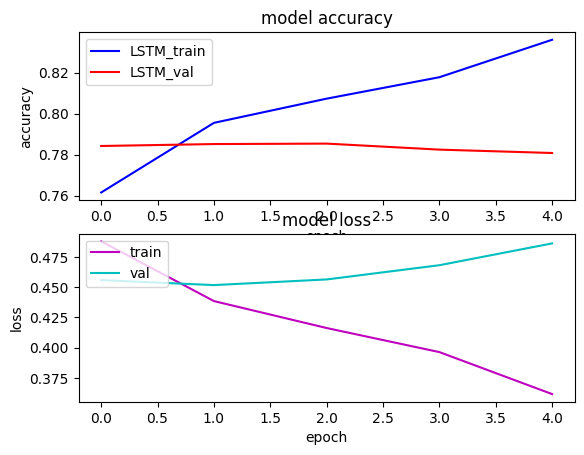

In [25]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(history.history['accuracy'], c= 'b')
ax1.plot(history.history['val_accuracy'], c='r')
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

ax2.plot(history.history['loss'], c='m')
ax2.plot(history.history['val_loss'], c='c')
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc = 'upper left')

El modelo dará una predicción con la capa sigmoide con un valor en el rango (0 - 1), por lo que se pueden clasificar las dos clases definiendo un umbral, que suele ser de 0.5. Si el valor es mayor que este umbral, el `tweet` será clasificado como positivo, sino, será clasificado como negativo.

In [26]:
scores = model.predict(test_data['text'], batch_size=10000)                 # [0.86]
y_pred_1d = ["Positivo" if score > 0.5 else "Negativo" for score in scores] # ['Positive']

32/32 [==============================] - 3s 73ms/step


#### Matriz de confusión

La matriz de confusión resume el rendimiento del modelo en tareas de clasificación, ya que muestra la cantidad de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.

<Figure size 600x600 with 0 Axes>

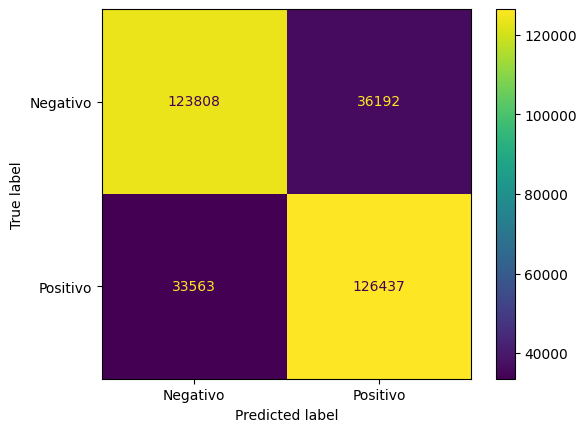

In [27]:
# Se calcula la matriz de confusión
cm = confusion_matrix(test_data['sentiment'].to_list(), y_pred_1d)
plt.figure(figsize=(6,6))

# Se muestra la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Negativo', 'Positivo'])
disp.plot()
plt.show()

#### Métricas de clasificación

Ahora se muestran las métricas de `recall` y `precision`, además del `F1-Score`, que es la métrica que resume las dos primeras medidas en una sola.

In [28]:
print(classification_report(list(test_data['sentiment']), y_pred_1d))

              precision    recall  f1-score   support

    Negativo       0.79      0.77      0.78    160000
    Positivo       0.78      0.79      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [29]:
# Ejemplo de predicción de una frase (debe ser una serie de pandas)
model.predict(pd.Series('my dog is so lovely'))

1/1 [==============================] - 1s 550ms/step


array([[0.925426]], dtype=float32)